# Learning Uncertainty Sets

In [2]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lro
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

### Formulating the uncertainty set

We now formulate the uncertainty set slightly differently, where data and a loss function is passed as parameters instead of the uncertainty set parameters. The new parameters for the uncertainty set, $A$ and $b$, will be trained through differentiable optimization. 

Box uncertainty: $\{ u \mid\| Au + b \|_\infty \leq 1 \}$ 

- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 

Ellipsoidal uncertainty: $\{u \mid \| Au + b \|_p \leq 1 \}$ 

- $p$ : integer, optional  
  * Order of the norm. Default 2.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 


Budget uncertainty: 

1. train the box portion only: $\{u \mid \| Au + b \|_\infty \leq 1, \| u \|_1 \leq \rho_2\}$ 
2. train the 1-norm portion only: $\{u \mid \| u \|_\infty \leq \rho_1, \| Au + b \|_1 \leq 1\}$ 
- train_box: boolean, optional
  * If True, train the box portion only. Default True. 
- $\rho_1$ : float, optional
  * Box scaling. Default 1.0.
- $\rho_2$ : float, optional
  * 1-norm scaling. Default 1.0.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set.
  

### Formulating the loss function

The loss function passed into the uncertainty set must be a function that returns torch tensors with gradient information. The function must take in as inputs all the variables defined in the Robust Problem, as well as the data used to evaluate the loss. There may also be other inputs to the function, depending on the type of loss.  
An example of a violation loss is 
$$
\mathcal{L}(\mathcal{D}, x) = f(x)  + \frac{\lambda }{N}\sum_{i=1}^{N} g(d_i,x)_+,
$$
where $\mathcal{D}$ is the dataset, $\lambda$ is the weight on the violation loss, $N$ is the total number of datapoints in the dataset, and $d_i$ is sample $i$ of the dataset. 

### Training the uncertainty set

To train the uncertainty set, after setting up the robust problem, call `problem.train()`, with optional parameters to control whether to train only $\epsilon$ or both $A$ and $b$, the total number of iterations, the learning rate of the problem, the optimizer to use, and initial values for $A$ and $b$. 

The function will return a pandas DataFrame with information on the iterates, as well as the reformulated problem.


### Example 1: Linear Portfolio


Consider the simple portfolio problem where we want to select a portfolio of stocks that maximizes returns. The Robust Problem is formulated as
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & -u^Tx \leq  \tau\\
&\mathbf{1}^Tx = 1, x \geq 0,
\end{array}
$$
where $u$ is the uncertain parameter. 

We train an ellipsoidal uncertainty set with $p = 2$, and consider the violation loss $\tau + \lambda(-u^Tx - \tau)_+$, where $\lambda = 1$ is the scaling for the sum of violations. 

In [3]:
# The violation loss function, in torch tensors
def violation_loss(t_soln, x_soln, data, lmbda=1):
    return t_soln + lmbda * torch.mean(
        torch.maximum(-data @ x_soln - t_soln, torch.tensor(0., requires_grad=True))), t_soln

# Functions to generate data
def normal_returns_scaled(N, m, scale):
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = normal_returns_scaled(weights, m, scales[i])
    return d[0:N, :]

# Generate data
num_stocks = 2
N = 100
data = data_modes(N,num_stocks,[1,2,3])

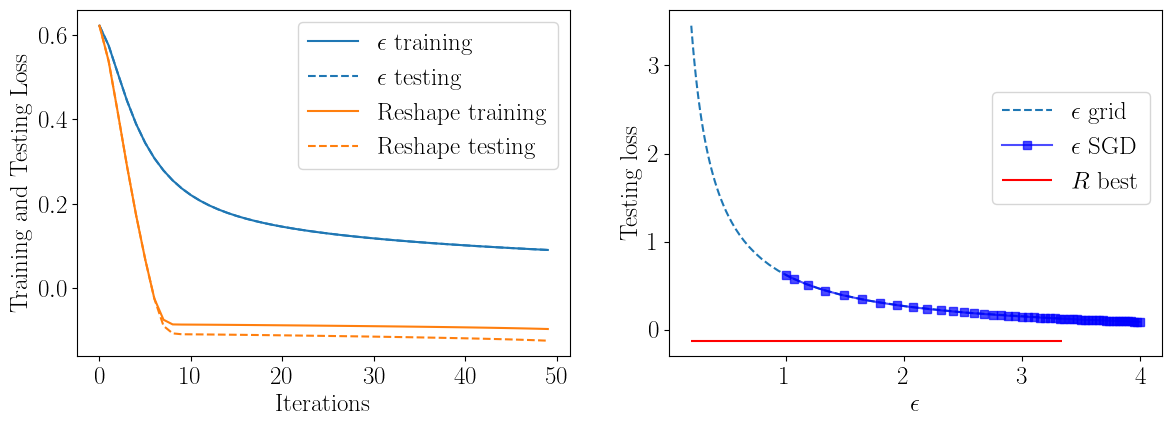

In [4]:

# Formulate the uncertainty set and uncertain parameter
unc_set = lro.Ellipsoidal(data=data, loss=violation_loss)
u = lro.UncertainParameter(num_stocks, uncertainty_set=unc_set)

# Formulate the Robust Problem
x = cp.Variable(num_stocks)
t = cp.Variable()

objective = cp.Minimize(t)
cons = [-u @ x <= t]
cons += [cp.sum(x) == 1, x >= 0]

prob_robust = lro.RobustProblem(objective, cons)
s = 20

# Train only epsilon
df, newprob, A_fin, b_fin= prob_robust.train(eps=True, lr=0.1, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)

# Train A and b
df1, newprob, A_fin, b_fin = prob_robust.train(lr=0.1, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)

# Grid search epsilon
dfgrid, newprob = prob_robust.grid(epslst = np.linspace(0.3, 5, 50), seed = s)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df['step'], df['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df['step'], df['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df["A_norm"],df["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend(bbox_to_anchor=(1, 0.8))
plt.show()


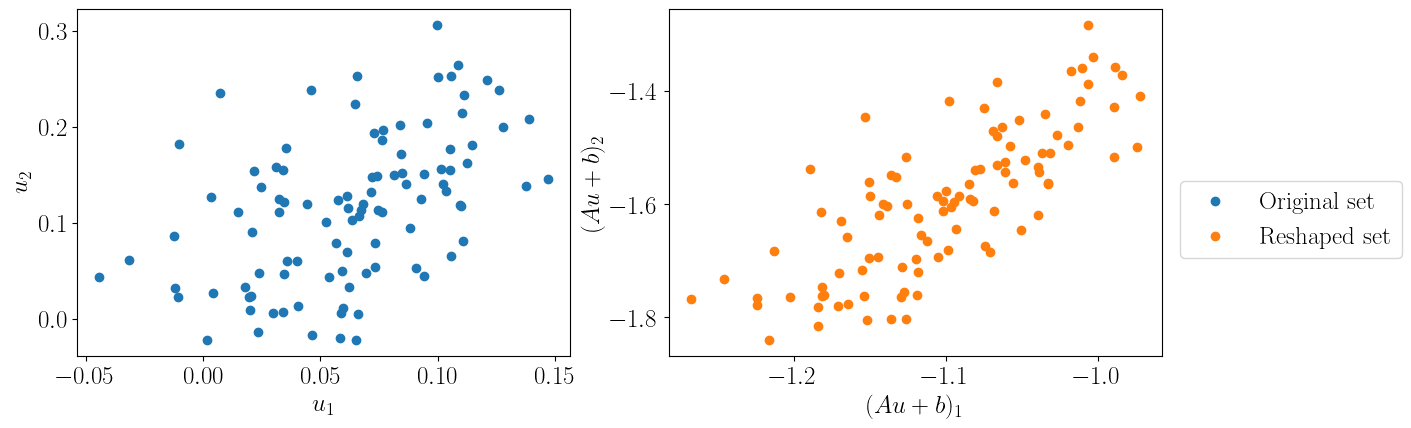

In [5]:
newdat = data@A_fin + b_fin
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.scatter(data[:,0],data[:,1],color="tab:blue", label=r"Original set")
ax1.set_ylabel("$u_2$")
ax1.set_xlabel("$u_1$")
ax2.scatter(newdat[:,0],newdat[:,1],color="tab:orange", label="Reshaped set")
ax2.set_ylabel("$(Au + b)_2$")
ax2.set_xlabel("$(Au + b)_1$")
lgd = fig.legend(loc = "lower right", bbox_to_anchor=(1.08, 0.3))
plt.show()

(100, 100)


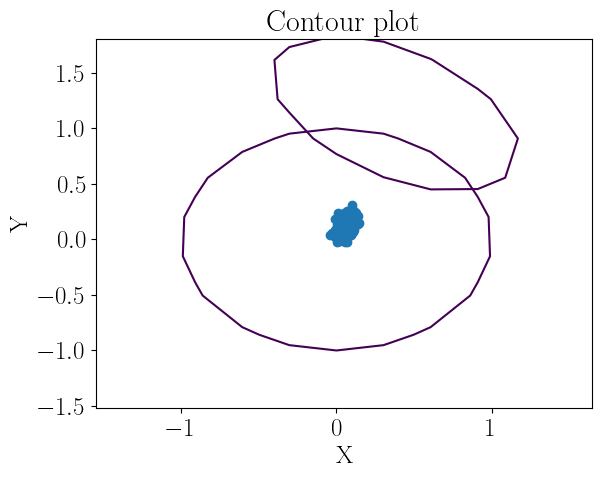

In [12]:
n = 100
X = np.linspace(-10,20,n)
Y = np.linspace(-15,20,n)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
Z_1 = np.zeros((n,n))
Z_2 = np.zeros((n,n))
# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(n):
    for j in range(n):
        Z_1[i,j] = np.linalg.norm(A_fin@ [x[i,j], y[i,j]] + b_fin)
        Z_2[i,j] = np.linalg.norm([x[i,j],y[i,j]])
print(Z_1.shape)
plt.title("Contour plot")
# Set x axis label for the contour plot
plt.xlabel("X")
# Set y axis label for the contour plot

plt.ylabel("Y")

plt.contour(x,y,Z_1, [1])
plt.contour(x,y,Z_2, [1])
plt.scatter(data[:,0],data[:,1])

translate_num = 1.5
min_x = np.min(data[:,0]) - translate_num
max_x = np.max(data[:,0]) + translate_num
min_y = np.min(data[:,1]) - translate_num
max_y = np.max(data[:,1]) + translate_num

plt.ylim(min_y,max_y)
plt.xlim(min_x,max_x)
plt.show()

### Example 2: Quadratic uncertainty
We consider a problem with quadratic uncertainty, 

$$g(u,x) = \sum_{i=1}^n g_i(u,x), \quad \text{where } \quad g_i(u,x) = -(1/2)u^T(P_ix_i)u.$$ 
We have each $P_i\in \mathbf{R}^{n\times n}$ a symmetric positive definite matrix, $u \in \mathbf{R}^n$ from an ellipsoidal set, and $x \in \mathbf{R}^{n}_{+}$. 
The robust formulation is 

$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & -(1/2)\sum_{i=1}^n (u^TP_iu)x_i  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& \mathbf{1}^Tx = 1\\
& x \geq 0, \quad x \leq 1,
\end{array}
$$

where $\theta$ encodes the training parameters $(A,b)$. We again consider the violation loss.

In [25]:
# Define the loss function
def loss(t,x,data,l = 2): 
    cur_sum = 0
    for i in range(data.shape[0]):
        cur_sum = cur_sum + torch.maximum(torch.sum(torch.tensor([-0.5*data[i]@torch.tensor(P[ind],requires_grad = True)
                                                                  *x[ind]@data[i] for ind in range(n)], requires_grad = True)) - t, 
                                          torch.tensor(0., requires_grad=True))
    return t + l*cur_sum/data.shape[0], t

#Generate data
P = {}
P_inv = {}
n = 2
N = 50
for i in range(n):
    P[i] = datasets.make_spd_matrix(n, random_state=i)
    P_inv[i] = sc.linalg.sqrtm(np.linalg.inv(P[i]))
data = data_modes(N,n,[1,2,3])

In [26]:
# Formulate the uncertainty set and uncertain parameter
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data = data, 
                                                    loss = loss))

# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.sum([-0.5*lro.uncertain_atoms.quad_form.quad_form(u, P[i]*x[i]) for i in range(n)]) <= t]
constraints += [cp.sum(x)==1]
constraints += [x >= 0, x <= 1]

prob = lro.RobustProblem(objective, constraints)

s = 135
# Train only epsilon
df_eps, newprob, A_fin, b_fin = prob.train(eps = True, lr = 0.1, step=50, momentum = 0.8, optimizer = "SGD", initeps = 0.4, seed = s)

# Train A and b
df1, newprob, A_fin, b_fin = prob.train(lr = 0.1, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps =0.4)

df2, newprob, A_fin, b_fin = prob.train(lr = 0.1, step=50, momentum = 0.8, optimizer = "SGD", seed = s)

# Grid search epsilon
dfgrid, newprob = prob.grid(epslst = np.linspace(0.3, 2, 40), seed = s)


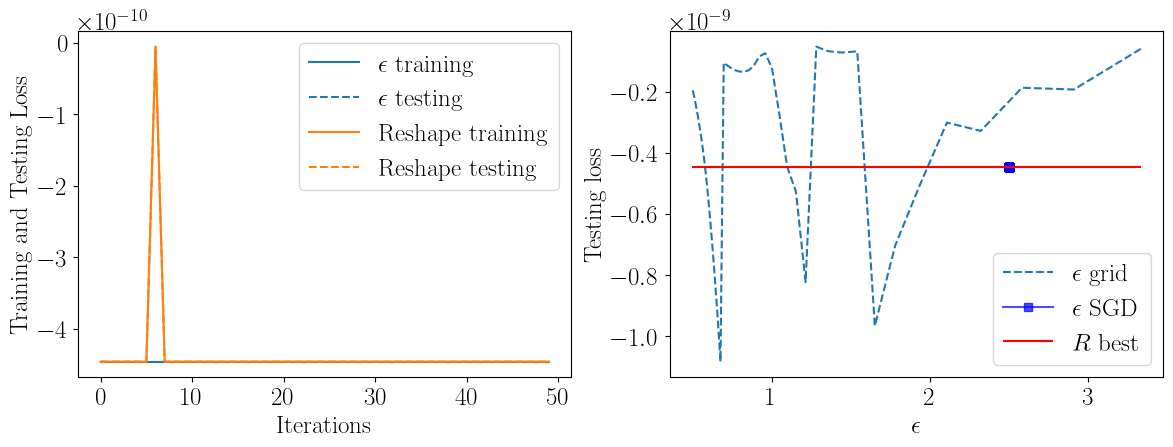

In [27]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_eps['step'], df_eps['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_eps['step'], df_eps['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_eps["A_norm"],df_eps["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend()
plt.show()


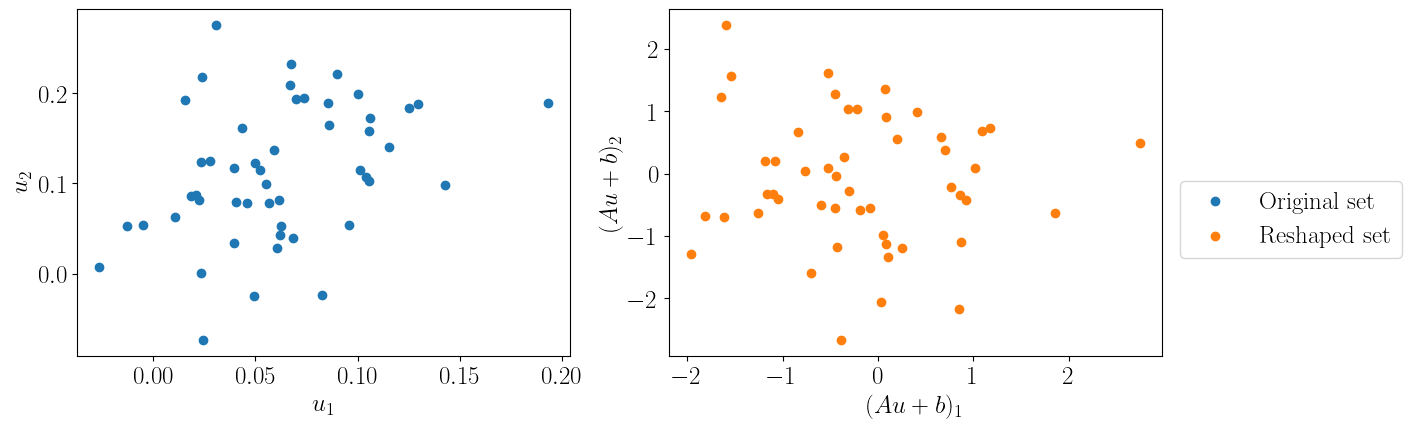

In [28]:
newdat = data@A_fin + b_fin
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.scatter(data[:,0],data[:,1],color="tab:blue", label=r"Original set")
ax1.set_ylabel("$u_2$")
ax1.set_xlabel("$u_1$")
ax2.scatter(newdat[:,0],newdat[:,1],color="tab:orange", label="Reshaped set")
ax2.set_ylabel("$(Au + b)_2$")
ax2.set_xlabel("$(Au + b)_1$")
lgd = fig.legend(loc = "lower right", bbox_to_anchor=(1.08, 0.3))
plt.show()

(100, 100)


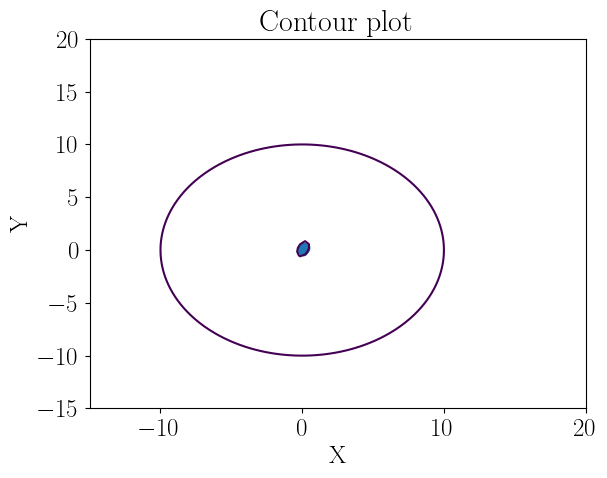

In [29]:
n = 100
X = np.linspace(-15,20,n)
Y = np.linspace(-15,20,n)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
Z_1 = np.zeros((n,n))
Z_2 = np.zeros((n,n))
# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(n):
    for j in range(n):
        Z_1[i,j] = np.linalg.norm(A_fin@ [x[i,j], y[i,j]] + b_fin)
        Z_2[i,j] = np.linalg.norm([x[i,j],y[i,j]])
print(Z_1.shape)
plt.title("Contour plot")
# Set x axis label for the contour plot
plt.xlabel("X")
# Set y axis label for the contour plot

plt.ylabel("Y")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
plt.contour(x,y,Z_1, [10])
plt.contour(x,y,Z_2, [10])
plt.scatter(data[:,0],data[:,1])
plt.show()

In [31]:
np.linalg.svd(A_fin)

(array([[-0.94662623,  0.32233334],
        [ 0.32233334,  0.94662623]]),
 array([25.99337604, 13.22226088]),
 array([[-0.94660336,  0.3224005 ],
        [ 0.3224005 ,  0.94660336]]))

### Example 2: Max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

In [65]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([2.,3.])
p = np.array([3.,4.])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

# Formulate loss function
def loss(t,x, data,l = 2): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))), t

def gen_demand(n, N):
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)

In [66]:
# Formulate uncertainty set
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lro.RobustProblem(objective, constraints)

s = 13
# Train only epsilon
df_eps, newprob, A_fin, b_fin = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)

# Train A and b
df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps=1)

# Grid search epsilon
dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
 

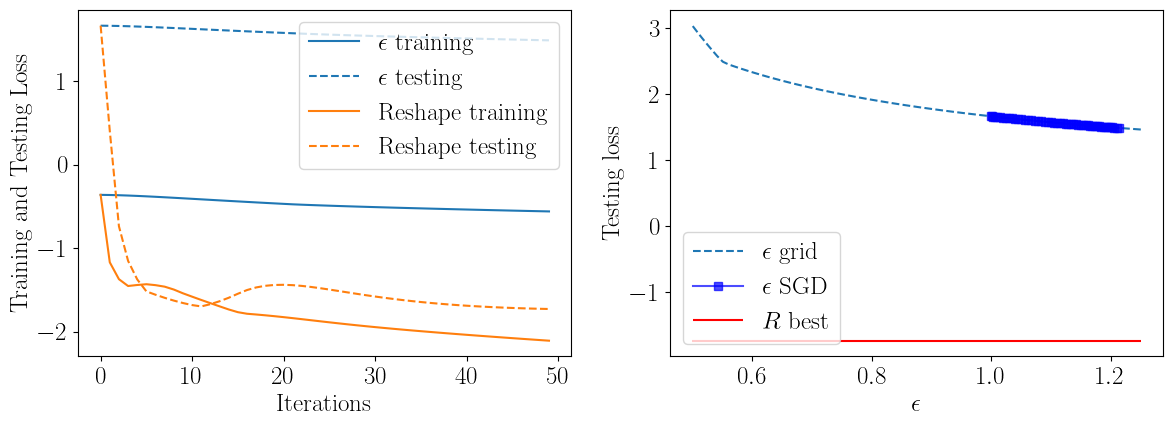

In [67]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_eps['step'], df_eps['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_eps['step'], df_eps['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_eps["A_norm"],df_eps["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend()
plt.show()


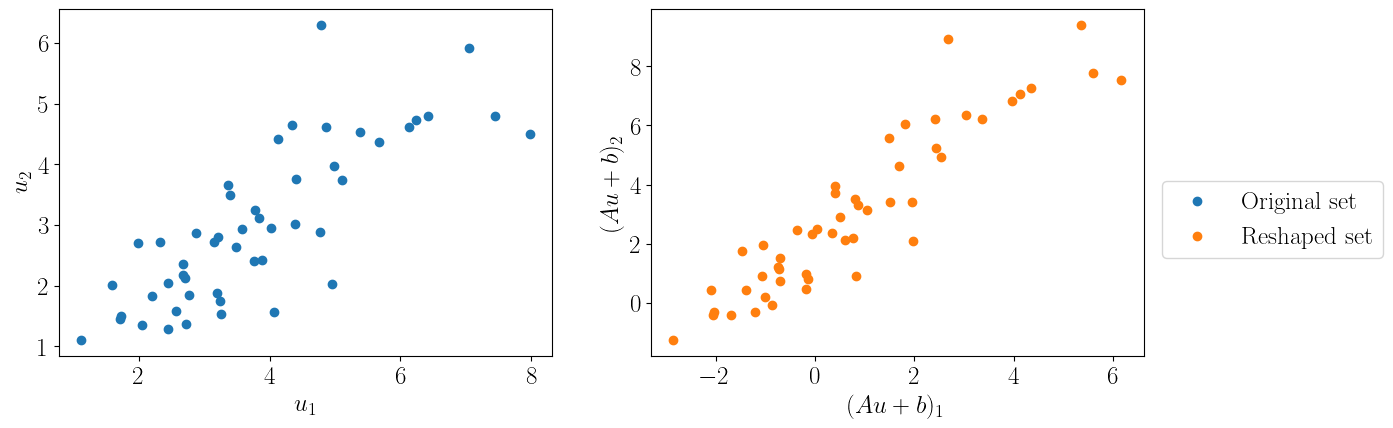

In [68]:
newdat = data@A_fin + b_fin
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.scatter(data[:,0],data[:,1],color="tab:blue", label=r"Original set")
ax1.set_ylabel("$u_2$")
ax1.set_xlabel("$u_1$")
ax2.scatter(newdat[:,0],newdat[:,1],color="tab:orange", label="Reshaped set")
ax2.set_ylabel("$(Au + b)_2$")
ax2.set_xlabel("$(Au + b)_1$")
lgd = fig.legend(loc = "lower right", bbox_to_anchor=(1.08, 0.3))
plt.show()

(100, 100)


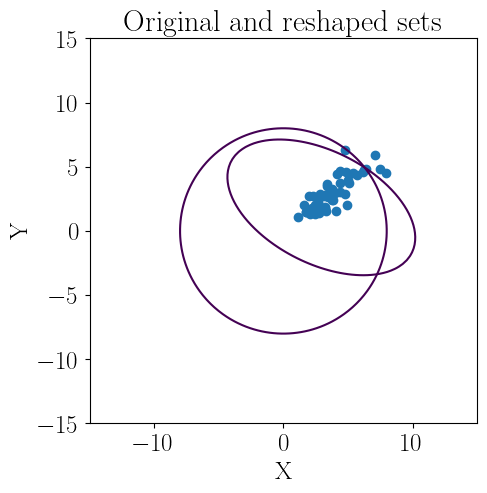

In [69]:
plt.figure(figsize=(5, 5))
n = 100
X = np.linspace(-15,15,n)
Y = np.linspace(-15,15,n)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
Z_1 = np.zeros((n,n))
Z_2 = np.zeros((n,n))
# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(n):
    for j in range(n):
        Z_1[i,j] = np.linalg.norm(A_fin@ [x[i,j], y[i,j]] + b_fin)
        Z_2[i,j] = np.linalg.norm([x[i,j],y[i,j]])
print(Z_1.shape)
plt.title("Original and reshaped sets")
# Set x axis label for the contour plot
plt.xlabel("X")
# Set y axis label for the contour plot

plt.ylabel("Y")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
plt.contour(x,y,Z_1, [8], color = "green")
plt.contour(x,y,Z_2, [8])
plt.scatter(data[:,0],data[:,1])
plt.show()